In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as layers
import tensorflow.contrib.distributions as ds

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
config = tf.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8, \
                        allow_soft_placement=True, device_count = {'CPU': 8})
sess = tf.InteractiveSession(config = config)

In [4]:
target_loc = -0.25
target_scale = 0.05

In [5]:
eps = 1e-10

In [6]:
batch_size = 1000

In [7]:
def prepare_data(n_samples):
    data = []
    labels = []
    nuisances = []
    
    for i in range(n_samples):
        sig_bkg = np.random.uniform(low = 0.0, high = 1.0, size = 1)
        if sig_bkg > 0.5:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [0.0, nuisance], cov = np.array([[1, -0.5], [-0.5, 1]]), size = 1).flatten())
            labels.append(1.0)
        else:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [1.0, nuisance], cov = np.eye(2), size = 1).flatten())
            labels.append(0.0)
            
        nuisances.append(nuisance)
    data = np.array(data)
    labels = np.array(labels)
    nuisances = np.array(nuisances)
    
    return data, labels, nuisances.flatten()

In [8]:
num_samples = 100000
data_train, labels_train, nuisances_train = prepare_data(num_samples)
nuisances_train = np.expand_dims(nuisances_train, axis = 1)
labels_train = np.expand_dims(labels_train, axis = 1)

In [9]:
train_bkg = labels_train == 0
bkg_data_train = data_train[train_bkg.flatten()]
bkg_labels_train = labels_train[train_bkg.flatten()]

In [10]:
train_sig = labels_train == 1
sig_data_train = data_train[train_sig.flatten()]
sig_labels_train = labels_train[train_sig.flatten()]

In [11]:
def classifier(data_in, name):
    with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
        lay = layers.relu(data_in, 40)
        lay = layers.relu(lay, 40)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 2)
        normalized_outputs = layers.softmax(outputs)

    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)

    return outputs, normalized_outputs, these_vars

In [12]:
def EM_network(data, name):
    with tf.variable_scope(name, reuse = tf.AUTO_REUSE):       
        lay = layers.relu(data, 40)
        lay = layers.relu(lay, 40)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)
        
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)
    
    return outputs, these_vars

In [13]:
def make_EM_loss(data_P, data_Q, name):
    local_EM_network_name = name + "_EM_net"
    
    # generator output
    T_P, EM_vars = EM_network(data_P, name = local_EM_network_name)
    
    # target
    T_Q, _ = EM_network(data_Q, name = local_EM_network_name)

    EM_loss = tf.reduce_mean(T_P, axis = 0) - tf.reduce_mean(T_Q, axis = 0)
    
    batch_size_dyn = tf.cast(tf.shape(T_P)[0], tf.int32)
    rand = tf.random.uniform(shape = (batch_size_dyn, 1), minval = 0.0, maxval = 1.0)
    
    # add gradient penalty
    x_grad = tf.math.add(tf.math.multiply(rand, data_P),
                         tf.math.multiply(tf.math.subtract(1.0, rand), data_Q))
    x_grad_EM, _ = EM_network(x_grad, name = local_EM_network_name)
    grad = tf.gradients(x_grad_EM, x_grad)[0]
    
    grad_norm = tf.math.sqrt(tf.reduce_sum(tf.math.square(grad), axis = 1) + eps)
    
    grad_pen = tf.reduce_mean(tf.math.square(grad_norm - 1.0))

    EM_loss_grad_pen = EM_loss[0] + 10 * grad_pen

    return EM_loss_grad_pen, EM_vars, -EM_loss

In [122]:
def make_plots():
    batch_size_test = 10000
    target_test = np.random.normal(loc = target_loc, scale = target_scale, size = (batch_size_test, 1))
        
    inds_bkg = np.random.choice(len(bkg_data_train), int(batch_size_test / 2))
    bkg_batch_data = bkg_data_train[inds_bkg]
    bkg_batch_labels = bkg_labels_train[inds_bkg]

    inds_sig = np.random.choice(len(sig_data_train), int(batch_size_test / 2))
    sig_batch_data = sig_data_train[inds_sig]
    sig_batch_labels = sig_labels_train[inds_sig]
    
    class_pred_bkg = sess.run(class_out_single, feed_dict = {data_in: bkg_batch_data, labels_in: bkg_batch_labels})
    class_pred_sig = sess.run(class_out_single, feed_dict = {data_in: sig_batch_data, labels_in: sig_batch_labels})
        
    plt.clf()
    plt.hist([np.squeeze(target_test), np.squeeze(class_pred_bkg), np.squeeze(class_pred_sig)], label = ['bkg target', 'classifier bkg', 'classifier sig'], histtype = 'step', density = True, bins = 50)
    plt.xlim([-0.5, 0.0])
    plt.ylim([0, 10])
    plt.legend()

In [15]:
data_in = tf.placeholder(tf.float32, [None, 2], name = 'data_in')
target_in = tf.placeholder(tf.float32, [None, 1], name = 'target_in')
labels_in = tf.placeholder(tf.float32, [None, 1], name = 'labels_in')

In [16]:
class_out, norm_class_out, gen_vars = classifier(data_in, "gen")

In [17]:
labels_one_hot = tf.squeeze(tf.one_hot(tf.dtypes.cast(labels_in, tf.int32), depth = 2))

In [18]:
classification_loss = tf.losses.softmax_cross_entropy(onehot_labels = labels_one_hot, logits = norm_class_out)

In [19]:
bkg_truth = tf.where(tf.math.less(labels_in, 1))

In [20]:
class_out_single = tf.expand_dims(class_out[:,1], axis = 1)

In [21]:
class_out_bkg = tf.gather_nd(class_out_single, bkg_truth)
class_out_bkg = tf.expand_dims(class_out_bkg, axis = 1)

In [22]:
EM_lossval, EM_vars, EM_dist = make_EM_loss(class_out_bkg, target_in, "EM_loss_obj")

In [23]:
total_loss = classification_loss + EM_dist

In [24]:
train_EM = tf.train.AdamOptimizer(learning_rate = 5e-3, beta1 = 0.0, beta2 = 0.5).minimize(EM_lossval, var_list = EM_vars)

In [25]:
train_gen = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.0, beta2 = 0.5).minimize(EM_dist, var_list = gen_vars)

In [26]:
train_class_total_loss = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.0, beta2 = 0.5).minimize(total_loss, var_list = gen_vars)

In [27]:
train_class = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.0, beta2 = 0.5).minimize(classification_loss, var_list = gen_vars)

In [40]:
sess.run(tf.global_variables_initializer())

In [178]:
init_critic = tf.variables_initializer(EM_vars)

In [185]:
sess.run(init_critic)

In [187]:
for i in range(200):
    target = np.random.normal(loc = target_loc, scale = target_scale, size = (batch_size, 1))
    inds = np.random.choice(len(bkg_data_train), batch_size)
    data_batch = bkg_data_train[inds]
    labels_batch = bkg_labels_train[inds]
    
    sess.run(train_EM, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch})

    EM_dist_val = sess.run(EM_dist, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch})
    print("EM_dist = {}".format(EM_dist_val))

EM_dist = [0.01784618]
EM_dist = [0.01483873]
EM_dist = [0.01632118]
EM_dist = [0.01740743]
EM_dist = [0.01648913]
EM_dist = [0.01717007]
EM_dist = [0.01478389]
EM_dist = [0.01453142]
EM_dist = [0.02103731]
EM_dist = [0.01278923]
EM_dist = [0.01745604]
EM_dist = [0.0117452]
EM_dist = [0.01836996]
EM_dist = [0.01343191]
EM_dist = [0.01741756]
EM_dist = [0.01603058]
EM_dist = [0.01969416]
EM_dist = [0.01537956]
EM_dist = [0.02084211]
EM_dist = [0.01569737]
EM_dist = [0.01981172]
EM_dist = [0.01386051]
EM_dist = [0.02244923]
EM_dist = [0.02150802]
EM_dist = [0.01897602]
EM_dist = [0.01339903]
EM_dist = [0.01235914]
EM_dist = [0.01501293]
EM_dist = [0.01924494]
EM_dist = [0.01737118]
EM_dist = [0.0191154]
EM_dist = [0.01121032]
EM_dist = [0.01463257]
EM_dist = [0.01468648]
EM_dist = [0.02112971]
EM_dist = [0.0140285]
EM_dist = [0.01574492]
EM_dist = [0.0139529]
EM_dist = [0.01666832]
EM_dist = [0.01458722]
EM_dist = [0.01988675]
EM_dist = [0.01206346]
EM_dist = [0.01868829]
EM_dist = [0.01

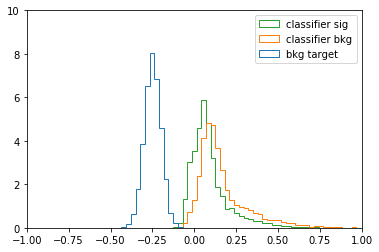

In [44]:
make_plots()
plt.show()

In [45]:
def perform_training(training_op, epochs, ME_epochs):
    for i in range(0, epochs):
        # prepare noise
        for j in range(ME_epochs):
            target = np.random.normal(loc = target_loc, scale = target_scale, size = (batch_size, 1))
            inds = np.random.choice(len(bkg_data_train), batch_size)
            bkg_batch_data = bkg_data_train[inds]
            bkg_batch_labels = bkg_labels_train[inds]

            sess.run(train_EM, feed_dict = {data_in: bkg_batch_data, target_in: target, labels_in: bkg_batch_labels})

        target = np.random.normal(loc = target_loc, scale = target_scale, size = (int(batch_size / 2), 1))
        inds = np.random.choice(len(data_train), batch_size)
        data_batch = data_train[inds]

        inds_bkg = np.random.choice(len(bkg_data_train), int(batch_size / 2))
        bkg_batch_data = bkg_data_train[inds_bkg]
        bkg_batch_labels = bkg_labels_train[inds_bkg]

        inds_sig = np.random.choice(len(sig_data_train), int(batch_size / 2))
        sig_batch_data = sig_data_train[inds_sig]
        sig_batch_labels = sig_labels_train[inds_sig]

        data_batch = np.concatenate([sig_batch_data, bkg_batch_data])
        labels_batch = np.concatenate([sig_batch_labels, bkg_batch_labels])
        
        sess.run(training_op, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch})
        EM_dist_val = sess.run(EM_dist, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch})
        critic_loss = sess.run(EM_lossval, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch})
        class_lossval = sess.run(classification_loss, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch})

        print("W = {}".format(EM_dist_val))
        print("critic loss = {}".format(critic_loss))
        print("class loss = {}".format(class_lossval))

        #save_plots("WGAN_training/epoch_" + str(i).zfill(5) + ".png")

In [194]:
perform_training(train_class_total_loss, epochs = 1, ME_epochs = 300)

W = [0.00380835]
critic loss = 0.009147841483354568
class loss = 0.6538085341453552


In [56]:
perform_training(train_class, epochs = 100, ME_epochs = 300)

W = [0.04910219]
critic loss = -0.04368305206298828
class loss = 0.7056863903999329
W = [0.03576565]
critic loss = -0.031983718276023865
class loss = 0.7016664147377014
W = [0.04677147]
critic loss = -0.041941165924072266
class loss = 0.7047515511512756
W = [0.04754257]
critic loss = -0.042457252740859985
class loss = 0.7038659453392029
W = [0.04030138]
critic loss = -0.03557813912630081
class loss = 0.7046754360198975
W = [0.04274517]
critic loss = -0.03822920098900795
class loss = 0.7037270665168762
W = [0.04542476]
critic loss = -0.0409938246011734
class loss = 0.7047550678253174
W = [0.04577142]
critic loss = -0.033603645861148834
class loss = 0.7025068402290344
W = [0.04692531]
critic loss = -0.042072806507349014
class loss = 0.7018827795982361
W = [0.05178511]
critic loss = -0.04757292941212654
class loss = 0.7020091414451599
W = [0.05592316]
critic loss = -0.05149534344673157
class loss = 0.7003287076950073
W = [0.0471496]
critic loss = -0.04247903823852539
class loss = 0.700967

In [71]:
perform_training(train_gen, epochs = 20, ME_epochs = 300)

W = [0.05281776]
critic loss = -0.046695198863744736
class loss = 0.6674094200134277
W = [0.05014825]
critic loss = -0.037474364042282104
class loss = 0.6632840633392334
W = [0.05823225]
critic loss = -0.0533597394824028
class loss = 0.6638917326927185
W = [0.04700744]
critic loss = -0.036338575184345245
class loss = 0.6641810536384583
W = [0.05443782]
critic loss = -0.047229617834091187
class loss = 0.6669999361038208
W = [0.04641163]
critic loss = -0.038591381162405014
class loss = 0.6668498516082764
W = [0.04290015]
critic loss = -0.03716224431991577
class loss = 0.6664512753486633
W = [0.04972005]
critic loss = -0.043012917041778564
class loss = 0.6647153496742249
W = [0.04718584]
critic loss = -0.03900592029094696
class loss = 0.665987491607666
W = [0.04797709]
critic loss = -0.03874361515045166
class loss = 0.6662145853042603
W = [0.04696822]
critic loss = -0.03952150046825409
class loss = 0.6675902009010315
W = [0.04652452]
critic loss = -0.039733629673719406
class loss = 0.6684

In [201]:
make_plots()
#plt.show()
plt.savefig("shaped_classifier.pdf")

In [124]:
data_test = np.loadtxt("data_test.txt")
labels_test = np.loadtxt("labels_test.txt")

In [130]:
pred = sess.run(norm_class_out, feed_dict = {data_in: data_test})[:,0]

In [127]:
from sklearn import metrics

In [196]:
fpr, tpr, thresholds = metrics.roc_curve(labels_test, pred)

In [197]:
LL_pred = np.loadtxt("LL_evaluated.csv")

In [198]:
fpr_LL, tpr_LL, thresholds_LL = metrics.roc_curve(labels_test, LL_pred)

In [202]:
# plot both of them into the same graph
fig, ax = plt.subplots()
ax.plot(tpr, fpr, label = 'shaped classifier', c = 'red')
ax.plot(fpr_LL, tpr_LL, label = 'analytic likelihood', c = 'black', ls = 'dashed')
leg = ax.legend(loc = 'lower right')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
#plt.show()
plt.savefig("shaped_classifier_ROC.pdf")

In [200]:
1 - metrics.roc_auc_score(labels_test, pred)

0.7529593337151719

In [167]:
metrics.roc_auc_score(labels_test, LL_pred)

0.7783846885778357